# Primary Biliary Cirrhosis: final notebook

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pickle

from tdsurv import CoxPH, concordance_index, unroll

In [2]:
with open("../data/pbc-seqs.pkl", "rb") as f:
    data = pickle.load(f)

seqs = data["seqs"]
cs = data["cs"]
ts = data["ts"]
cols = data["cols"]

n, horizon, d = seqs.shape

# Truncate sequences.
#cs = cs | (ts > 1)
#ts = np.minimum(ts, 1)
#horizon = 2

## Understanding the features

In [3]:
model = CoxPH(horizon=horizon, n_feats=d)
model.fit(seqs, ts, cs, lambda_=1.0, l2=0.01, verbose=True)

Optimization terminated successfully.
         Current function value: 381.745701
         Iterations: 23
         Function evaluations: 26
         Gradient evaluations: 26
         Hessian evaluations: 220


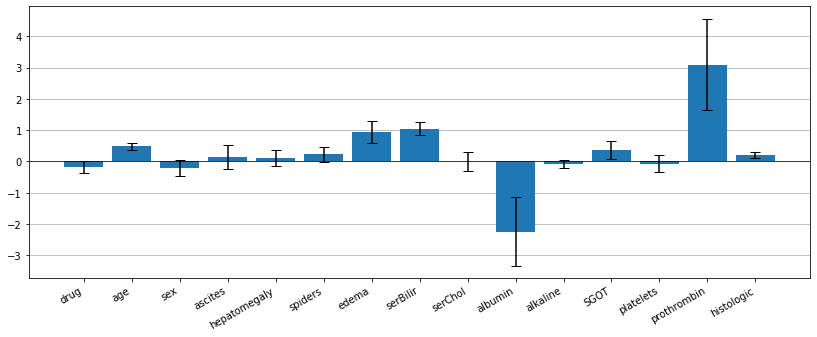

In [4]:
idx = np.arange(d)
params, std = model.params_with_stderr(seqs, ts, cs, cutoff=d)

fig, ax = plt.subplots(figsize=(14, 5))
ax.bar(idx, params, yerr=std, capsize=5)
ax.set_xticks(idx)
ax.axhline(0.0, color="black", lw=0.7)
ax.grid(axis="y")
ax.set_axisbelow(True)
ax.set_xticklabels(cols, ha="right", rotation=30);

Mayo risk score:

- age
- serBilir
- albumin
- prothrombin time
- edema

In [5]:
params_gt = model.params[:d]

## Sample efficiency

In [6]:
# 5-fold cross-validation
rng = np.random.default_rng(seed=42)
n_folds = 5
zs = np.append(((n / n_folds) * np.arange(n_folds)).astype(int), n)
idx = rng.permutation(n)

def get_fold(fold):
    z1 = zs[fold]
    z2 = zs[fold + 1]
    idx_train = np.concatenate((idx[:z1], idx[z2:]))
    idx_valid = idx[z1:z2]
    return (
        (seqs[idx_train], ts[idx_train], cs[idx_train]),
        (seqs[idx_valid], ts[idx_valid], cs[idx_valid]),
    )

### Metric 1: predictive log-likelihood

In [7]:
%%time
model = CoxPH(horizon=horizon, n_feats=d)

sizes = 20 * np.arange(1, 11)

res1_is = np.zeros((n_folds, len(sizes)))
res1_lm = np.zeros((n_folds, len(sizes)))
res1_td = np.zeros((n_folds, len(sizes)))

for fold in range(n_folds):
    (seqs_t, ts_t, cs_t), (seqs_v, ts_v, cs_v) = get_fold(fold)
    for i, size in enumerate(sizes):
        print(".", end="")
        seqs_, ts_, cs_ = unroll(seqs_t[:size], ts_t[:size], cs_t[:size])
        # Initial state.
        model.params = np.zeros_like(model.params)
        model.fit(seqs_t[:size], ts_t[:size], cs_t[:size], lambda_=1.0, l2=0.1)
        res1_is[fold, i] = model.loglike(seqs_v[:, 0], ts_v, cs_v)
        # Landmarking.
        model.params = np.zeros_like(model.params)
        model.fit(seqs_, ts_, cs_, lambda_=1.0, l2=0.1)
        res1_lm[fold, i] = model.loglike(seqs_v[:, 0], ts_v, cs_v)
        # Temporal difference.
        model.params = np.zeros_like(model.params)
        model.fit(seqs_, ts_, cs_, lambda_=0.0, n_iters=100, l2=0.0)
        res1_td[fold, i] = model.loglike(seqs_v[:, 0], ts_v, cs_v)
    print()

..........
..........
..........
..........
..........
CPU times: user 3min 59s, sys: 16.7 s, total: 4min 15s
Wall time: 1min 42s


Text(0.5, 0, 'Number of patients')

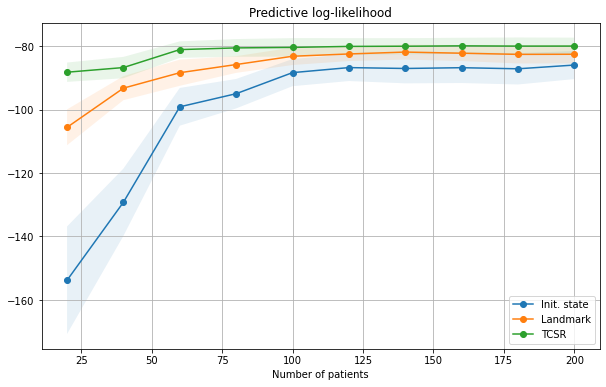

In [8]:
fig, ax = plt.subplots(figsize=(10, 6))

for res, label in ((res1_is, "Init. state"), (res1_lm, "Landmark"), (res1_td, "TCSR")):
    mean = res.mean(axis=0)
    std = res.std(axis=0) / np.sqrt(n_folds)
    ax.plot(sizes, mean, marker="o", label=label)
    ax.fill_between(sizes, mean - std, mean + std, alpha=0.1)

ax.legend(loc="lower right")
ax.grid()
ax.set_title("Predictive log-likelihood")
ax.set_xlabel("Number of patients")

### Metric 2: integrated Brier score

In [9]:
%%time
model = CoxPH(horizon=horizon, n_feats=d)

sizes = 20 * np.arange(1, 11)

res2_is = np.zeros((n_folds, len(sizes)))
res2_lm = np.zeros((n_folds, len(sizes)))
res2_td = np.zeros((n_folds, len(sizes)))

for fold in range(n_folds):
    (seqs_t, ts_t, cs_t), (seqs_v, ts_v, cs_v) = get_fold(fold)
    for i, size in enumerate(sizes):
        print(".", end="")
        seqs_, ts_, cs_ = unroll(seqs_t[:size], ts_t[:size], cs_t[:size])
        # Initial state.
        model.params = np.zeros_like(model.params)
        model.fit(seqs_t[:size], ts_t[:size], cs_t[:size], lambda_=1.0, l2=0.1)
        res2_is[fold, i] = model.integrated_brier_score(seqs_v[:, 0], ts_v, cs_v)
        # Landmarking.
        model.params = np.zeros_like(model.params)
        model.fit(seqs_, ts_, cs_, lambda_=1.0, l2=0.1)
        res2_lm[fold, i] = model.integrated_brier_score(seqs_v[:, 0], ts_v, cs_v)
        # Temporal difference.
        model.params = np.zeros_like(model.params)
        model.fit(seqs_, ts_, cs_, lambda_=0.0, n_iters=100, l2=0.0)
        res2_td[fold, i] = model.integrated_brier_score(seqs_v[:, 0], ts_v, cs_v)
    print()

..........
..........
..........
..........
..........
CPU times: user 4min 15s, sys: 15.8 s, total: 4min 30s
Wall time: 1min 56s


Text(0.5, 0, 'Number of patients')

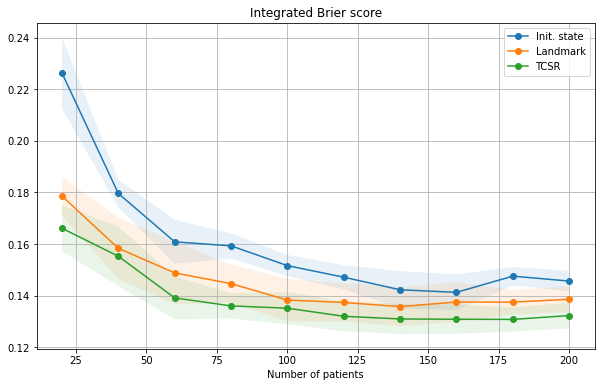

In [10]:
fig, ax = plt.subplots(figsize=(10, 6))

for res, label in ((res2_is, "Init. state"), (res2_lm, "Landmark"), (res2_td, "TCSR")):
    mean = res.mean(axis=0)
    std = res.std(axis=0) / np.sqrt(n_folds)
    ax.plot(sizes, mean, marker="o", label=label)
    ax.fill_between(sizes, mean - std, mean + std, alpha=0.1)

ax.legend()
ax.grid()
ax.set_title("Integrated Brier score")
ax.set_xlabel("Number of patients")

### Metric 3: concordance index

In [11]:
%%time
model = CoxPH(horizon=horizon, n_feats=d)

sizes = 20 * np.arange(1, 11)

res3_is = np.zeros((n_folds, len(sizes)))
res3_lm = np.zeros((n_folds, len(sizes)))
res3_td = np.zeros((n_folds, len(sizes)))

for fold in range(n_folds):
    (seqs_t, ts_t, cs_t), (seqs_v, ts_v, cs_v) = get_fold(fold)
    for i, size in enumerate(sizes):
        print(".", end="")
        seqs_, ts_, cs_ = unroll(seqs_t[:size], ts_t[:size], cs_t[:size])
        # Initial state.
        model.params = np.zeros_like(model.params)
        model.fit(seqs_t[:size], ts_t[:size], cs_t[:size], lambda_=1.0, l2=0.0)
        res3_is[fold, i] = concordance_index(model.score(seqs_v[:, 0]), ts_v, cs_v)
        # Landmarking.
        model.params = np.zeros_like(model.params)
        model.fit(seqs_, ts_, cs_, lambda_=1.0, l2=0.0)
        res3_lm[fold, i] = concordance_index(model.score(seqs_v[:, 0]), ts_v, cs_v)
        # Temporal difference.
        model.params = np.zeros_like(model.params)
        model.fit(seqs_, ts_, cs_, lambda_=0.0, n_iters=100, l2=0.0)
        res3_td[fold, i] = concordance_index(model.score(seqs_v[:, 0]), ts_v, cs_v)
    print()

..........
..........
..........
..........
..........
CPU times: user 4min 34s, sys: 19.4 s, total: 4min 53s
Wall time: 1min 48s


Text(0.5, 0, 'Number of patients')

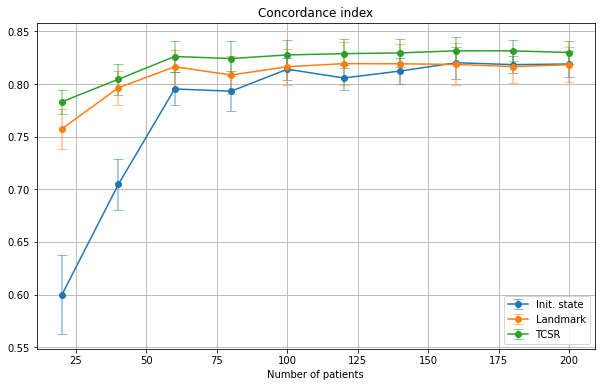

In [12]:
fig, ax = plt.subplots(figsize=(10, 6))

for res, label in ((res3_is, "Init. state"), (res3_lm, "Landmark"), (res3_td, "TCSR")):
    mean = res.mean(axis=0)
    std = res.std(axis=0) / np.sqrt(n_folds)
    #ax.plot(sizes, mean, marker="o", label=label)
    #ax.fill_between(sizes, mean - std, mean + std, alpha=0.1)
    markers, caps, bars = ax.errorbar(sizes, mean, yerr=std, capsize=5, marker="o", label=label)
    [elem.set_alpha(0.5) for elem in bars + caps]

ax.legend(loc="lower right")
ax.grid()
ax.set_title("Concordance index")
ax.set_xlabel("Number of patients")

### Metric 4: RMSE

In [13]:
%%time
model = CoxPH(horizon=horizon, n_feats=d)

sizes = 20 * np.arange(1, 11)

res4_is = np.zeros((n_folds, len(sizes)))
res4_lm = np.zeros((n_folds, len(sizes)))
res4_td = np.zeros((n_folds, len(sizes)))

for fold in range(n_folds):
    (seqs_t, ts_t, cs_t), (seqs_v, ts_v, cs_v) = get_fold(fold)
    for i, size in enumerate(sizes):
        print(".", end="")
        seqs_, ts_, cs_ = unroll(seqs_t[:size], ts_t[:size], cs_t[:size])
        # Initial state.
        model.params = np.zeros_like(model.params)
        model.fit(seqs_t[:size], ts_t[:size], cs_t[:size], lambda_=1.0, l2=0.5)
        res4_is[fold, i] = np.linalg.norm(model.params[:d] - params_gt)
        # Landmarking.
        model.params = np.zeros_like(model.params)
        model.fit(seqs_, ts_, cs_, lambda_=1.0, l2=1.0)
        res4_lm[fold, i] = np.linalg.norm(model.params[:d] - params_gt)
        # Temporal difference.
        model.params = np.zeros_like(model.params)
        model.fit(seqs_, ts_, cs_, lambda_=0.5, n_iters=100, l2=0.0)
        res4_td[fold, i] = np.linalg.norm(model.params[:d] - params_gt)
    print()

..........
..........
..........
..........
..........
CPU times: user 7min 29s, sys: 14.2 s, total: 7min 43s
Wall time: 5min 32s


Text(0.5, 0, 'Number of patients')

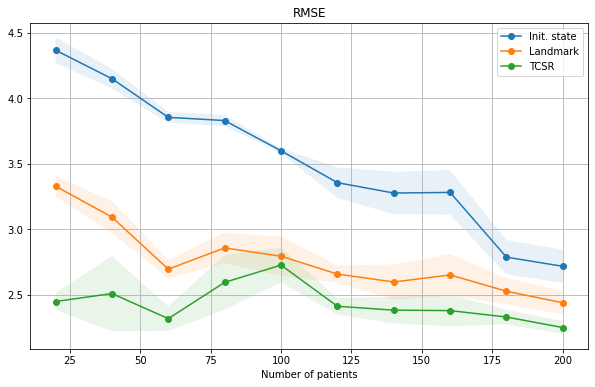

In [14]:
fig, ax = plt.subplots(figsize=(10, 6))

for res, label in ((res4_is, "Init. state"), (res4_lm, "Landmark"), (res4_td, "TCSR")):
    mean = res.mean(axis=0)
    std = res.std(axis=0) / np.sqrt(n_folds)
    ax.plot(sizes, mean, marker="o", label=label)
    ax.fill_between(sizes, mean - std, mean + std, alpha=0.1)

ax.legend()
ax.grid()
ax.set_title("RMSE")
ax.set_xlabel("Number of patients")

## Save results for further plotting

In [15]:
with open("../data/fig-pbc2.pkl", "wb") as f:
    pickle.dump({
        "xs": sizes,
        "loglike": (res1_is, res1_lm, res1_td),
        "brier": (res2_is, res2_lm, res2_td),
        "concord": (res3_is, res3_lm, res3_td),
        "rmse": (res4_is, res4_lm, res4_td),
    }, f)